In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
##########################
save_history = True # if true, updates portfolio and platform history files.
##########################
today = pd.to_datetime('today').normalize()
loans_df = pd.read_csv('data/concatenated.csv')
cash_df = pd.read_csv('data/cash.csv', index_col='platform_account_name')
transactions_df = pd.read_csv('data/transactions.csv')
platform_dict = { 'loanpad':'Loanpad 60d Access','proplend':'Proplend','crowdproperty':'CrowdProperty AutoInvest','invest_fund':'Invest & Fund','assetz_capital':'Assetz Capital 90d Access','kuflink':'Kuflink 24m Term 28133' }
col_list = ['Paid in capital','Distr capital','Int bearing','Non bearing','Accr int','Residual value','DPI','RVPI','TVPI','Inv mnths','TVPI CAGR','Net AER','Blended LTV','No loans','Avg loan amt','Avg term','Max term','Avg ttm','Max ttm','Avg ext','Ext 90d','Non-perform','Long default','Short default','Int default']
format_dict = { 'Paid in capital': '£{0:,.2f}','Distr capital': '£{0:,.2f}','Int bearing': '£{0:,.2f}','Non bearing': '£{0:,.2f}','Accr int': '£{0:,.2f}','Residual value': '£{0:,.2f}','DPI': '{0:,.2f}', 'RVPI': '{0:,.2f}', 'TVPI' : '{0:,.2f}','Inv mnths': '{:,.0f}','TVPI CAGR': '{:,.1%}','Net AER': '{:,.1%}','No loans': '{:,.0f}','Avg loan amt': '£{0:,.2f}','Blended LTV': '{:,.0%}','Avg term': '{:,.0f}','Max term': '{:,.0f}','Avg ttm': '{:,.0f}','Max ttm': '{:,.0f}','Avg ext': '{:,.0f}','Ext 90d': '{:,.0%}','Non-perform': '{:,.0%}','Long default': '£{0:,.0f}','Short default': '£{0:,.0f}','Int default': '£{0:,.0f}','Dev sector': '{:.0%}', 'Comm sector': '{:.0%}','No a/c': '{:,.0f}','Avg a/c amt': '£{0:,.0f}'}
colours_list = ['green','blue','red','orange','purple','pink']
def save_platform_csv(platform): # function to update platform_history.csv for all platform accounts
    exec(platform + "_df = pd.read_csv('data/" + platform + "_history.csv', index_col=0, parse_dates=[0])") # read platform _history.csv
    exec(platform + "_df.loc[today] = platform_row") # append platform row
    exec(platform + "_df.to_csv('data/" + platform + "_history.csv', index=True)") # save platform _history.csv

### Platforms

In [3]:
platform_df = pd.DataFrame(columns=col_list)
for platform in platform_dict:
    platform_account_name = platform_dict[platform]
    platform_loans = loans_df.loc[(loans_df['platform_account_name'] == platform_account_name) & (loans_df['loan_part_status'] != 'Repaid')]
    platform_int_bearing = platform_loans['loan_part_amt'].sum() + cash_df.loc[platform_account_name]['ib_cash'].sum()
    platform_non_bearing = cash_df.loc[platform_account_name]['nonib_cash']
    platform_accrued_int = cash_df.loc[platform_account_name]['accrued_int']
    platform_residual_value = platform_int_bearing + platform_non_bearing + platform_accrued_int
    platform_extended_pct = platform_loans.loc[platform_loans['loan_part_maturity_extended_days'] > 90, 'loan_part_amt'].sum() / platform_loans['loan_part_amt'].sum()
    platform_nonperform_pct = platform_loans.loc[platform_loans['loan_part_status'].isin(['Short Default', 'Long Default', 'Interest Default']), 'loan_part_amt'].sum() / platform_loans['loan_part_amt'].sum()
    platform_avg_loan_amt = platform_loans['loan_part_amt'].sum() / platform_loans['loan_portion'].sum()
    platform_transactions = transactions_df.loc[transactions_df['platform_account_name'] == platform_account_name]
    platform_paid_in = platform_transactions.loc[platform_transactions['trx_type'] == 'Paid in', 'trx_amt'].abs().sum()
    platform_distributions = platform_transactions.loc[platform_transactions['trx_type'] == 'Distribution', 'trx_amt'].abs().sum()
    platform_dpi = np.where(platform_distributions != 0, platform_distributions/platform_paid_in, 0)
    platform_rvpi = platform_residual_value / platform_paid_in
    platform_invested_months = (pd.to_datetime('today').date() - pd.to_datetime(platform_transactions['trx_date'].min()).date()).days / 30.437
    platform_cagr = (platform_dpi + platform_rvpi)**(1/(platform_invested_months/12))-1
    platform_row = [platform_paid_in, platform_distributions, platform_int_bearing, platform_non_bearing, platform_accrued_int, platform_residual_value, platform_dpi, platform_rvpi, platform_dpi + platform_rvpi, platform_invested_months, platform_cagr, platform_loans['platform_weighted_net_aer'].sum(), platform_loans['platform_weighted_blended_ltv'].sum(), platform_loans['loan_portion'].sum(), platform_avg_loan_amt, platform_loans['platform_weighted_term_months'].sum(), platform_loans['loan_part_term_months'].max(), platform_loans['platform_weighted_ttm_months'].sum(), platform_loans['loan_part_ttm_days'].max()/33.437, platform_loans['platform_weighted_maturity_extended_days'].sum(), platform_extended_pct, platform_nonperform_pct, platform_loans.loc[platform_loans['loan_part_status'] == 'Long Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Short Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Interest Default', 'loan_part_amt'].sum()]
    if save_history == True:
        save_platform_csv(platform) # function to update platform_history.csv for all platform accounts
    platform_df.loc[platform_account_name] = platform_row
platform_df.sort_values(by='Residual value', ascending=False).style.format(format_dict)

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,TVPI CAGR,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
Loanpad 60d Access,"£5,000.00",£0.00,"£5,630.00",£6.92,£0.00,"£5,636.92",0.00,1.13,1.13,27,5.5%,6.6%,44%,230,£24.01,2,2,2,2,127,37%,1%,£0,£0,£31
Proplend,"£4,000.00",£324.17,"£3,000.00","£1,016.77",£0.00,"£4,016.77",0.08,1.00,1.09,27,3.7%,6.7%,50%,3,"£1,000.00",28,36,15,23,0,0%,67%,£0,"£1,000","£1,000"
Invest & Fund,"£3,350.00",£0.00,"£2,970.33",£616.39,£100.39,"£3,687.11",0.00,1.10,1.10,25,4.7%,7.2%,66%,17,£174.73,11,24,7,15,2,0%,8%,£0,£250,£0
Kuflink 24m Term 28133,"£2,000.00",£0.00,"£2,056.66",£0.00,£103.64,"£2,160.30",0.00,1.08,1.08,26,3.6%,8.2%,61%,160,£12.81,24,24,10,9,145,38%,18%,£0,£0,£372
CrowdProperty AutoInvest,"£2,000.00",£389.91,"£1,603.78",£0.00,£0.00,"£1,603.78",0.19,0.80,1.00,25,-0.2%,7.7%,62%,28,£57.28,15,23,6,13,-0,0%,71%,"£1,065",£69,£0
Assetz Capital 90d Access,"£1,009.61",£315.78,£646.91,£73.93,£0.00,£720.84,0.31,0.71,1.03,19,1.7%,4.1%,59%,150,£4.31,53,103,15,43,0,0%,22%,£19,£49,£72


In [4]:
portfolio_df = pd.read_csv('data/portfolio_history.csv', index_col=0, parse_dates=[0])
portfolio_paid_in = transactions_df.loc[transactions_df['trx_type'] == 'Paid in', 'trx_amt'].abs().sum()
portfolio_distributions = transactions_df.loc[transactions_df['trx_type'] == 'Distribution', 'trx_amt'].abs().sum()
portfolio_accrued_int = cash_df['accrued_int'].sum()
portfolio_int_bearing = loans_df['loan_part_amt'].sum() + cash_df['ib_cash'].sum()
portfolio_non_bearing = cash_df['nonib_cash'].sum()
portfolio_accrued_int = cash_df['accrued_int'].sum()
portfolio_residual_value = portfolio_int_bearing + portfolio_non_bearing + portfolio_accrued_int
portfolio_dpi = portfolio_distributions / portfolio_paid_in
portfolio_rvpi = portfolio_residual_value / portfolio_paid_in
portfolio_invested_months = (pd.to_datetime('today').date() - pd.to_datetime(transactions_df['trx_date'].min()).date()).days / 30.437
portfolio_cagr = (portfolio_dpi + portfolio_rvpi)**(1/(portfolio_invested_months/12))-1
portfolio_row = [portfolio_paid_in, portfolio_distributions, portfolio_int_bearing, portfolio_non_bearing, portfolio_accrued_int, portfolio_residual_value, portfolio_dpi, portfolio_rvpi, portfolio_dpi + portfolio_rvpi, portfolio_invested_months, portfolio_cagr, loans_df['portfolio_weighted_net_aer'].sum(), loans_df['portfolio_weighted_blended_ltv'].sum(), loans_df['loan_portion'].sum(), loans_df['loan_part_amt'].sum() / loans_df['loan_portion'].sum(), loans_df['portfolio_weighted_term_months'].sum(),loans_df['loan_part_term_months'].max(),loans_df['portfolio_weighted_ttm_months'].sum(),loans_df['loan_part_ttm_days'].max()/33.437,loans_df['portfolio_weighted_maturity_extended_days'].sum(),loans_df.loc[loans_df['loan_part_maturity_extended_days'] > 90, 'loan_part_amt'].sum() / loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'].isin(['Short Default', 'Long Default', 'Interest Default']), 'loan_part_amt'].sum() / loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Long Default', 'loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Short Default', 'loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Interest Default', 'loan_part_amt'].sum(), loans_df.loc[loans_df['platform_account_sector'] == 'Development']['loan_part_amt'].sum()/loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['platform_account_sector'] == 'Commercial']['loan_part_amt'].sum()/loans_df['loan_part_amt'].sum(),len(platform_dict),loans_df['loan_part_amt'].sum() / len(platform_dict),]
portfolio_df.loc[today] = portfolio_row
if save_history == True:
    portfolio_df.to_csv('data/portfolio_history.csv', index=True)
portfolio_df.sort_index(ascending=False).style.format_index(lambda s: s.strftime('%Y-%m')).format(format_dict)

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,TVPI CAGR,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default,Dev sector,Comm sector,No a/c,Avg a/c amt
2024-09,"£17,359.61","£1,029.86","£15,907.68","£1,714.01",£204.03,"£17,825.72",0.06,1.03,1.09,27,3.7%,6.9%,54%,588,£26.86,15,103,7,43,64,18%,25%,"£1,084","£1,368","£1,475",77%,23%,6,"£2,632"
2024-08,£nan,£nan,"£15,146.49",£63.23,£nan,"£15,209.72",nan,nan,nan,nan,nan%,6.9%,54%,587,£25.67,14,103,7,43,44,15%,23%,£999,"£1,128","£1,318",76%,24%,6,"£2,511"
2024-08,£nan,£nan,"£15,146.49",£63.23,£nan,"£15,209.72",nan,nan,nan,nan,nan%,6.9%,54%,587,£25.67,14,103,7,43,44,15%,23%,£999,"£1,128","£1,318",76%,24%,6,"£2,511"
2024-06,£nan,£nan,"£14,783.45",£36.95,£nan,"£14,820.40",nan,nan,nan,nan,nan%,6.9%,53%,591,£24.82,14,103,7,43,42,16%,17%,£942,£245,"£1,310",75%,25%,6,"£2,445"
2024-03,£nan,£nan,"£14,885.53",£136.50,£nan,"£15,022.03",nan,nan,nan,nan,nan%,6.9%,54%,571,£25.81,15,86,8,44,49,20%,16%,£721,£400,"£1,224",75%,25%,6,"£2,457"
2023-12,£nan,£nan,"£14,817.62",£117.63,£nan,"£14,935.25",nan,nan,nan,nan,nan%,6.9%,54%,544,£27.07,15,78,9,47,nan,nan%,14%,£270,£531,"£1,228",74%,26%,6,"£2,454"
2023-11,£nan,£nan,"£14,448.47",£440.01,£nan,"£14,888.48",nan,nan,nan,nan,nan%,6.8%,54%,552,£25.82,15,78,9,48,nan,nan%,6%,£122,£479,£285,73%,27%,6,"£2,376"
2023-10,£nan,£nan,"£14,741.91",£89.84,£nan,"£14,831.75",nan,nan,nan,nan,nan%,6.5%,53%,559,£26.04,14,78,7,49,nan,nan%,4%,£122,£333,£200,74%,26%,6,"£2,426"
2023-09,£nan,£nan,"£14,606.01",£410.19,£nan,"£15,016.20",nan,nan,nan,nan,nan%,6.4%,54%,588,£24.69,14,83,7,50,nan,nan%,3%,£124,£118,£220,73%,27%,6,"£2,419"
2023-08,£nan,£nan,"£14,672.50",£119.50,£nan,"£14,792.00",nan,nan,nan,nan,nan%,6.3%,54%,596,£24.52,14,83,8,51,nan,nan%,4%,£122,£270,£225,74%,26%,6,"£2,436"


[Text(5, 0, '£24.01'),
 Text(5, 0, '£1,000.00'),
 Text(5, 0, '£57.28'),
 Text(5, 0, '£174.73'),
 Text(5, 0, '£4.31'),
 Text(5, 0, '£12.81')]

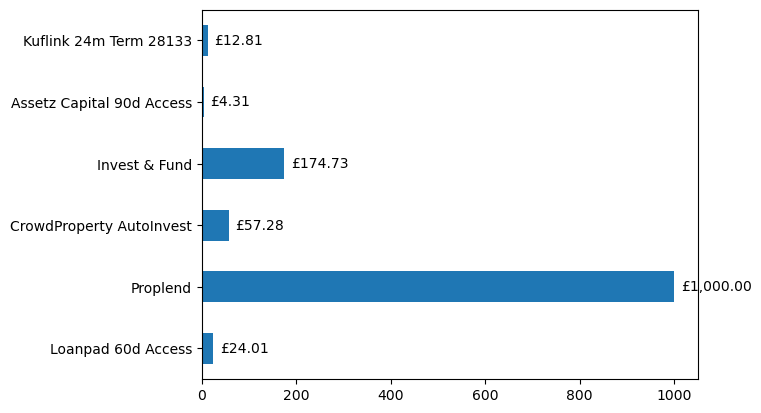

In [5]:
ax = platform_df.plot.barh(y='Avg loan amt', legend=False)
ax.bar_label(ax.containers[0], fmt='£{0:,.2f}', label_type='edge', padding=5)

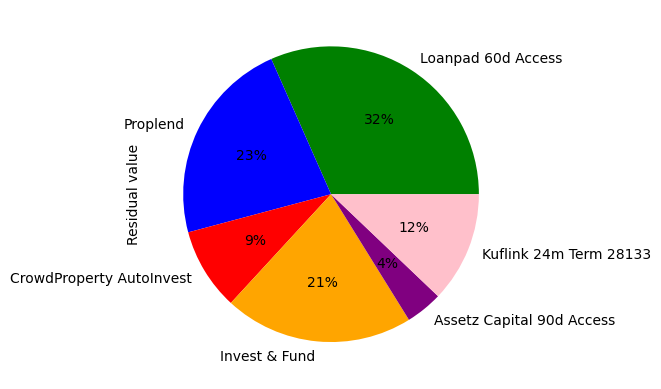

In [6]:
ax = platform_df['Residual value'].plot(kind='pie', colors=colours_list, autopct='%1.0f%%', legend=False)

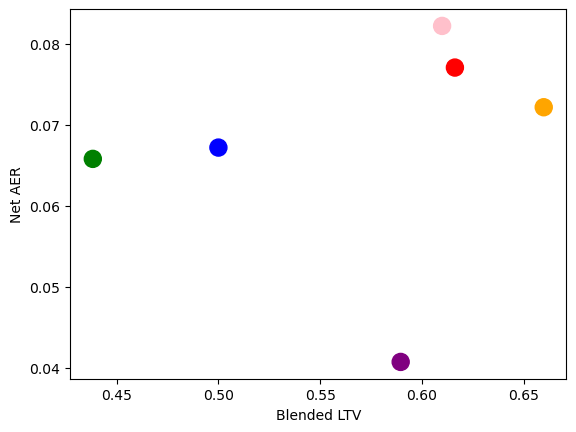

In [7]:
ax = platform_df.plot(kind='scatter', x='Blended LTV', y='Net AER', s=150, c=colours_list)